#### Import libraries

In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')
from imblearn.combine import SMOTEENN

In [2]:
sheet_name = "churn"

In [3]:
df = pd.read_excel("churnAnalysis.xlsx",sheet_name = sheet_name)

In [4]:
df.head()

,Customer_ID,Gender,Age,Married,State,Number_of_Referrals,Tenure_in_Months,Value_Deal,Phone_Service,Multiple_Lines,...,Payment_Method,Monthly_Charge,Total_Charges,Total_Refunds,Total_Extra_Data_Charges,Total_Long_Distance_Charges,Total_Revenue,Customer_Status,Churn_Category,Churn_Reason
0,19877-DEL,Male,35,No,Delhi,7,27,NaN,Yes,No,...,Credit Card,65.6,593.30,0.00,0,381.51,974.81,Stayed,Others,Others
1,58353-MAH,Female,45,Yes,Maharashtra,14,13,NaN,Yes,Yes,...,Credit Card,-4.0,542.40,38.33,10,96.21,610.28,Stayed,Others,Others
2,25063-WES,Male,51,No,West Bengal,4,35,Deal 5,Yes,No,...,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices
3,59787-KAR,Male,79,No,Karnataka,3,21,Deal 4,Yes,No,...,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
4,28544-TAM,Female,80,No,Tamil Nadu,3,8,NaN,Yes,No,...,Credit Card,83.9,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability


#### Data Preprocessing

In [5]:
df.drop(columns=['Customer_ID','Churn_Category','Churn_Reason'],inplace=True)

##### Label Encoding

In [6]:
columns_to_encode = [
    'Gender', 'Married', 'State', 'Value_Deal', 'Phone_Service', 'Multiple_Lines',
    'Internet_Service', 'Internet_Type', 'Online_Security', 'Online_Backup',
    'Device_Protection_Plan', 'Premium_Support', 'Streaming_TV', 'Streaming_Movies',
    'Streaming_Music', 'Unlimited_Data', 'Contract', 'Paperless_Billing',
    'Payment_Method'
]


In [7]:
label_encoding = {}
for col in columns_to_encode :
    label_encoding[col] = LabelEncoder()
    df[col] = label_encoding[col].fit_transform(df[col])
    

In [8]:
df.columns


Index(['Gender', 'Age', 'Married', 'State', 'Number_of_Referrals',
       'Tenure_in_Months', 'Value_Deal', 'Phone_Service', 'Multiple_Lines',
       'Internet_Service', 'Internet_Type', 'Online_Security', 'Online_Backup',
       'Device_Protection_Plan', 'Premium_Support', 'Streaming_TV',
       'Streaming_Movies', 'Streaming_Music', 'Unlimited_Data', 'Contract',
       'Paperless_Billing', 'Payment_Method', 'Monthly_Charge',
       'Total_Charges', 'Total_Refunds', 'Total_Extra_Data_Charges',
       'Total_Long_Distance_Charges', 'Total_Revenue', 'Customer_Status'],
      dtype='object')

In [10]:
df.Customer_Status = df.Customer_Status.map({'Stayed':0,'Churned':1})

#### Training Random Forest Model

In [11]:
x=df.drop('Customer_Status',axis=1)

In [12]:
y=df.Customer_Status


In [13]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2, random_state = 42)

In [14]:
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)

In [15]:
rf.fit(x_train,y_train)

RandomForestClassifier(random_state=42)

In [16]:
y_pred = rf.predict(x_test)

#### Evaluating Model

In [19]:
accuracy_score(y_test,y_pred)

0.8544093178036606

In [42]:
print(confusion_matrix(y_test,y_pred))

[[791  50]
 [125 236]]


In [20]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90       841
           1       0.83      0.65      0.73       361

    accuracy                           0.85      1202
   macro avg       0.84      0.80      0.81      1202
weighted avg       0.85      0.85      0.85      1202



##### As the number of Non-churners are higher than churners, this dataset is imbalanced, so we will use SMOTENN() to make it balance

In [45]:
sm = SMOTEENN()
x_resample,y_resample = sm.fit_resample(x,y)

In [46]:
xr_train,xr_test,yr_train,yr_test = train_test_split(x_resample,y_resample, test_size=0.2, random_state = 42)

In [47]:
rf_smote = RandomForestClassifier(n_estimators = 100, random_state = 42)

In [48]:
rf_smote.fit(xr_train,yr_train)

RandomForestClassifier(random_state=42)

In [49]:
yr_pred = rf_smote.predict(xr_test)

In [51]:
accuracy_score(yr_test,yr_pred)

0.943359375

In [52]:
print(confusion_matrix(yr_test,yr_pred))

[[449  39]
 [ 19 517]]


In [53]:
print(classification_report(yr_test,yr_pred))

              precision    recall  f1-score   support

           0       0.96      0.92      0.94       488
           1       0.93      0.96      0.95       536

    accuracy                           0.94      1024
   macro avg       0.94      0.94      0.94      1024
weighted avg       0.94      0.94      0.94      1024



##### Now the accuracy has improved from 85% to 94%

#### Let's do Hyperparameter Tuning of Random Forest Classifier

In [55]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 4, 6, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 8],
    'criterion': ['gini', 'entropy']
}

In [56]:
new_rf = RandomForestClassifier(random_state = 42)

In [57]:
grid_search = GridSearchCV(estimator = new_rf, param_grid=param_grid, cv=3, verbose=1, n_jobs=-1)

In [58]:
grid_search.fit(x_resample,y_resample)

Fitting 3 folds for each of 360 candidates, totalling 1080 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 10, None],
                         'min_samples_leaf': [1, 2, 4, 8],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             verbose=1)

In [60]:
print("Best Score : ", grid_search.best_score_)
print("Best Parameters : ",grid_search.best_params_)

Best Score :  0.9462845561789227
Best Parameters :  {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [66]:
best_rf = grid_search.best_estimator_

In [62]:
print(classification_report(yr_test,yr_pred))

              precision    recall  f1-score   support

           0       0.96      0.92      0.94       488
           1       0.93      0.96      0.95       536

    accuracy                           0.94      1024
   macro avg       0.94      0.94      0.94      1024
weighted avg       0.94      0.94      0.94      1024



In [32]:
imp = rf.feature_importances_
indices = np.argsort(imp)[::-1]
imp

array([0.00979801, 0.06595203, 0.00969014, 0.04273976, 0.03753659,
       0.04634721, 0.02178845, 0.00360385, 0.00866602, 0.01533938,
       0.02959965, 0.01670924, 0.00941645, 0.00822843, 0.01486226,
       0.00838477, 0.00808833, 0.00900695, 0.00694168, 0.13788952,
       0.01306115, 0.01918136, 0.09453256, 0.12291578, 0.00729352,
       0.01245538, 0.08439347, 0.13557806])

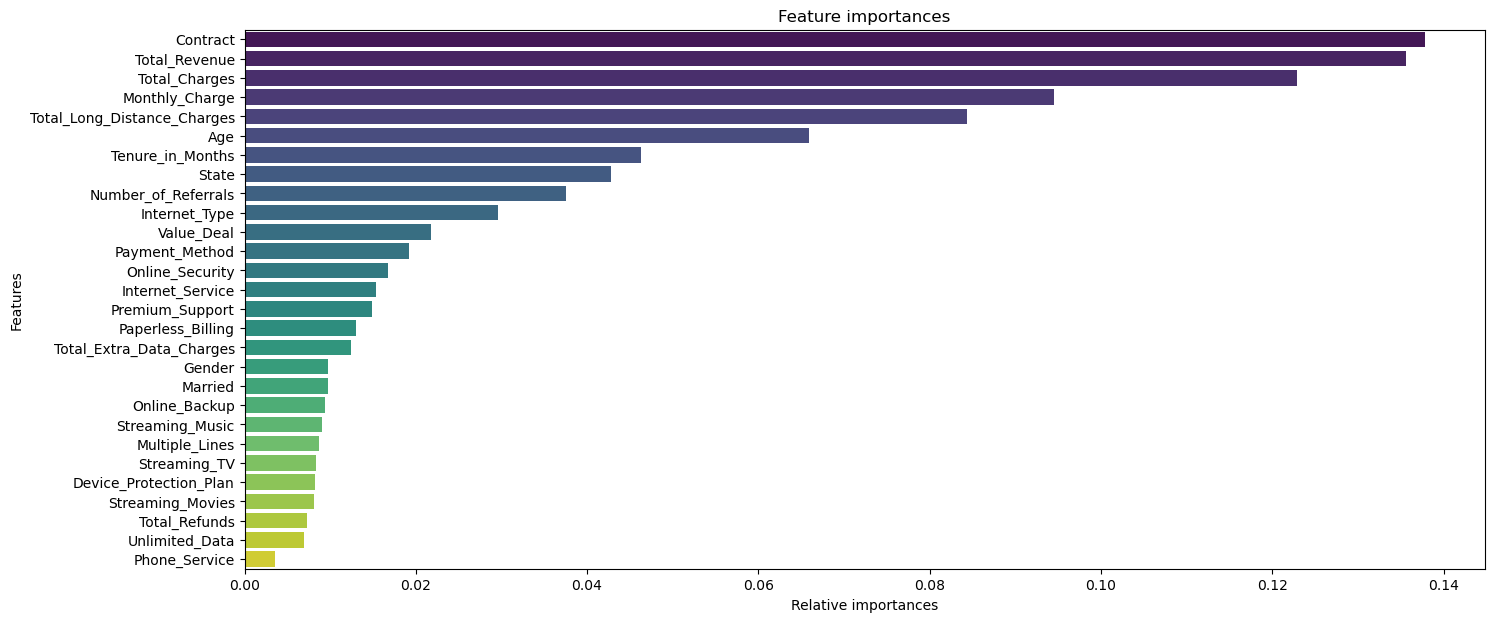

In [41]:
plt.figure(figsize = (16,7))
sns.barplot(x=imp[indices],y=x.columns[indices],palette='viridis')
plt.title('Feature importances')
plt.xlabel('Relative importances')
plt.ylabel('Features')
plt.show()

### Use Model for Prediction on New Data

In [68]:
df1 = pd.read_excel('churnAnalysis.xlsx',sheet_name = "join")

In [98]:
df1.shape


(411, 28)

In [70]:
df1.head()

,Customer_ID,Gender,Age,Married,State,Number_of_Referrals,Tenure_in_Months,Value_Deal,Phone_Service,Multiple_Lines,...,Payment_Method,Monthly_Charge,Total_Charges,Total_Refunds,Total_Extra_Data_Charges,Total_Long_Distance_Charges,Total_Revenue,Customer_Status,Churn_Category,Churn_Reason
0,93520-GUJ,Female,67,No,Gujarat,13,19,Deal 5,Yes,Yes,...,Bank Withdrawal,72.10,72.1,0.0,0,7.77,79.87,Joined,Others,Others
1,57256-BIH,Female,18,No,Bihar,9,7,NaN,Yes,No,...,Credit Card,19.85,57.2,0.0,0,9.36,66.56,Joined,Others,Others
2,72357-MAD,Female,53,No,Madhya Pradesh,14,12,Deal 5,Yes,No,...,Credit Card,44.30,44.3,0.0,0,42.95,87.25,Joined,Others,Others
3,66612-KAR,Female,58,Yes,Karnataka,11,18,NaN,Yes,No,...,Credit Card,19.95,58.0,0.0,0,8.07,66.07,Joined,Others,Others
4,22119-WES,Male,31,Yes,West Bengal,5,5,NaN,Yes,No,...,Credit Card,20.05,33.7,0.0,0,3.62,37.32,Joined,Others,Others


In [71]:
original = df1.copy()

In [73]:
df1.drop(['Customer_ID', 'Customer_Status', 'Churn_Category', 'Churn_Reason'], axis=1,inplace=True)

In [78]:
for col in df1.select_dtypes(include = ['object']).columns:
    df1[col]= label_encoding[col].transform(df1[col])

In [96]:
predictions = best_rf.predict(df1)

In [ ]:
original['Customer_Status_Predictions']=predictions

In [82]:
original=original[original['Customer_Status_Predictions']==1]

In [89]:
original.to_csv('PredictionChurn.csv',index=False)